### Loading Required Libraries

In [1]:
from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import Counter
from wordcloud import WordCloud 
from IPython.display import display

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = '/Users/nima/repository/Project_509'

### Section 1 - Clrean the reviews
Followings are done for cleaning the reviews:<br>
> Remove all stop words<br>
> Revmove punctuations <br>
> Add splace before and after emojis<br>
> Remove zero width joiners '\u200d' <br>
> Perform Stemming on words (i.e. working, worked, words are all converted to working)<br>


In [25]:
databse_file = 'database.db'
main = connect(databse_file)
df = pd.read_sql_query('SELECT id, course_name, star, helpful, text FROM reviews', main)
df.sample(5)

,id,course_name,star,helpful,text
54840,54840,learning-how-to-learn,5.0,0.0,\nExcellent course. The analogies used motivat...
1916,1916,ai-for-everyone,5.0,0.0,Everyone who want to learn Ai and who is want ...
22953,22953,foundations-data,5.0,0.0,It was great! It's a very good introduction to...
37550,37550,python-network-data,5.0,0.0,very good course
9011,9011,ai-for-everyone,4.0,0.0,Good course to engage initial AI concepts


In [28]:
tc = PreProcessing.TokenCleaner(remove_stopwords=True, return_as_string=False)

df['text_cleaned'] = df['text'].apply(tc.CleanText)
df.sample(5)

,id,course_name,star,helpful,text,text_cleaned
40247,40247,python-network-data,2.0,0.0,too many informations and things just went too...,"[mani, inform, thing, went, fast, first, two, ..."
18065,18065,excel-essentials,5.0,0.0,The course is very useful.,"[cours, veri, use]"
13798,13798,excel-essentials,5.0,0.0,Very Nice & informative. Both teachers have go...,"[veri, nice, inform, teacher, good, knowledg, ..."
46300,46300,python,5.0,0.0,Great Experience and platform to learn the cou...,"[great, experi, platform, learn, cours, thank,..."
11954,11954,excel-essentials,5.0,0.0,Course is very well designed . It helped me in...,"[cours, veri, well, design, help, understand, ..."


/var/folders/xf/plyvp1dd0bg7vd_kpskbsv_m0000gn/T/ipykernel_73869/3509249416.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['text_cleaned_count'], kde=False, ax=ax1, bins=40)


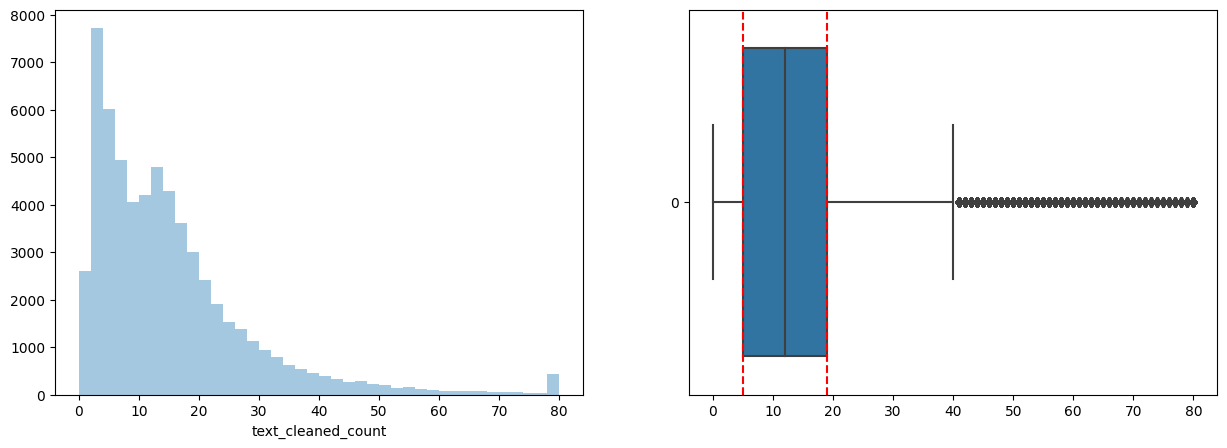

In [29]:
# count of elements in text_cleaned for each row
df['text_cleaned_count'] = df['text_cleaned'].apply(lambda x: len(x))

# combine the numbers that are over 80 in the chart -- this is useful for illustration purposes
# since there are not many reviews with more than 80 words
df['text_cleaned_count'] = df['text_cleaned_count'].apply(lambda x: 80 if x > 80 else x)


# plot two charts side by side  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Show the distribution of text_cleaned_count
sns.distplot(df['text_cleaned_count'], kde=False, ax=ax1, bins=40)

# seabord boxplot text_cleaned_count
# and label the percentile lines for 25, 50, 75
sns.boxplot(df['text_cleaned_count'], ax=ax2, orient="h")
ax2.axvline(df['text_cleaned_count'].quantile(0.25), color='r', linestyle='--')
ax2.axvline(df['text_cleaned_count'].quantile(0.75), color='r', linestyle='--')

plt.show()

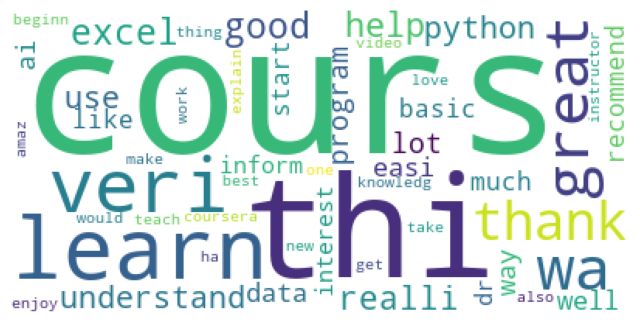

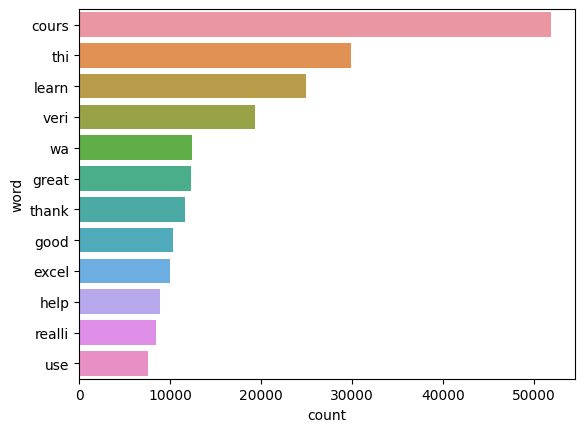

In [30]:
# use itertools to count  all the words in the text_cleaned column

word_counts = Counter(chain.from_iterable(df['text_cleaned']))

# ignore the words that are less than 5 times in the text_cleaned column
word_counts = {k:v for k,v in word_counts.items() if v > 5}

# convert the word_counts dict to a dataframe and sort it by the count
word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort_values(by='count', ascending=False)

# use  wordcloud library to show the top words used from the word_counts dataframe
wordcloud = WordCloud(background_color="white", max_words=50)
wordcloud.generate_from_frequencies(word_counts.set_index('word')['count'].to_dict())
plt.figure(figsize=(8, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# table of the top 12 words used
sns.barplot(x='count', y='word', data=word_counts.head(12))
plt.show()

In [31]:
# make a clean_sentence in df from the text_cleaned column join
df['clean_sentence'] = df['text_cleaned'].apply(lambda x: ' '.join(x))

review_text_clean = df[['id','clean_sentence']]

# rename id column to review_id
review_text_clean = review_text_clean.rename(columns={'id':'review_id'})

# change index name to id
review_text_clean.index.name = 'id'

review_text_clean.head(12)

,review_id,clean_sentence
id,,
0,0,got comprehens overview ai mean variou concept...
1,1,highli recommend anyon want start learn ai exp...
2,2,brilliantli deliv contain import stuff help pr...
3,3,equip right attitud ai project limit affect so...
4,4,got comprehens overview ai mean variou concept...
5,5,wonder veri insight cours clear lot doubt misc...
6,6,professor andrew ng excel explain complex topi...
7,7,fact wa total ignor ai could learn basic ai ga...
8,8,simpl yet veri inform interest length cours ni...


In [43]:
review_text_clean.to_sql('review_text_clean', main)

# sql statements to show all tables in the database and number of rows in each table
sql_show_tables = "SELECT name FROM sqlite_master WHERE type='table';"

pd.read_sql_query(sql, main)


,name
0,reviews
1,course
2,review_text_clean


In [42]:
main.commit()
main.close()